In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from xgboost import XGBRFClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Download data from csv

In [28]:
data = "car_evaluation.csv"
df = pd.read_csv(data)
df.columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'Class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,Class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safety    1727 non-null   object
 6   Class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Dividing data into training and test data

In [30]:
x, y = df.drop('Class', axis = 1), df['Class']
x_train, x_test, y_train, y_test, = train_test_split(x,y,test_size = 0.2,random_state=50)

Encoding categorical features and adjusts 'Class' labels by subtracting 1

In [31]:
encoder_x = ce.OrdinalEncoder(cols=df.columns[:-1])
x_train = encoder_x.fit_transform(x_train)
x_test = encoder_x.transform(x_test)
x_train.head()

,buying,maint,doors,persons,lug_boot,safety
824,1,1,1,1,1,1
264,2,2,2,2,2,2
90,2,3,3,1,3,2
861,1,1,3,2,1,2
353,2,1,2,3,2,1


In [32]:
encoder_y = ce.OrdinalEncoder(cols=['Class'])
y_train = encoder_y.fit_transform(y_train)
y_test = encoder_y.transform(y_test)
y_train['Class'] = list(map(lambda x: x-1, y_train['Class']))
y_test['Class'] = list(map(lambda x: x-1, y_test['Class']))
y_train.head()

,Class
824,0
264,1
90,0
861,1
353,0


## Random forest

In [33]:
param_grid = {
    'n_estimators': [100, 1000, 2000],
    'max_depth': [2, 5, 10]
}

In [34]:
rf = RandomForestClassifier(random_state=75)
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc_ovr')
grid_search_rf.fit(x_train, y_train)
print('Best Parameters: ', grid_search_rf.best_params_)
print('Best Score: ', grid_search_rf.best_score_)

Best Parameters:  {'max_depth': 10, 'n_estimators': 2000}
Best Score:  0.9972162032692775


In [35]:
rf_best = grid_search_rf.best_estimator_
y_pred = rf_best.predict(x_test)
y_score = rf_best.predict_proba(x_test)

Display confusion matrix, roc curve and classification report

In [36]:
def display_conf_matrix(conf_matrix):
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [37]:
def display_roc_curve(y_test, y_score):
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    unique_classes = lb.classes_

    for i in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 8))
    for i in unique_classes:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print('ROC AUC Score: ', f'{roc_auc_score(y_true_binary, y_score, multi_class="ovr"):.3f}')

In [38]:
def display_classification_report(y_test, y_pred):
    print('Classification Report')
    print('------------------------------------------------------')
    print(classification_report(y_test, y_pred))

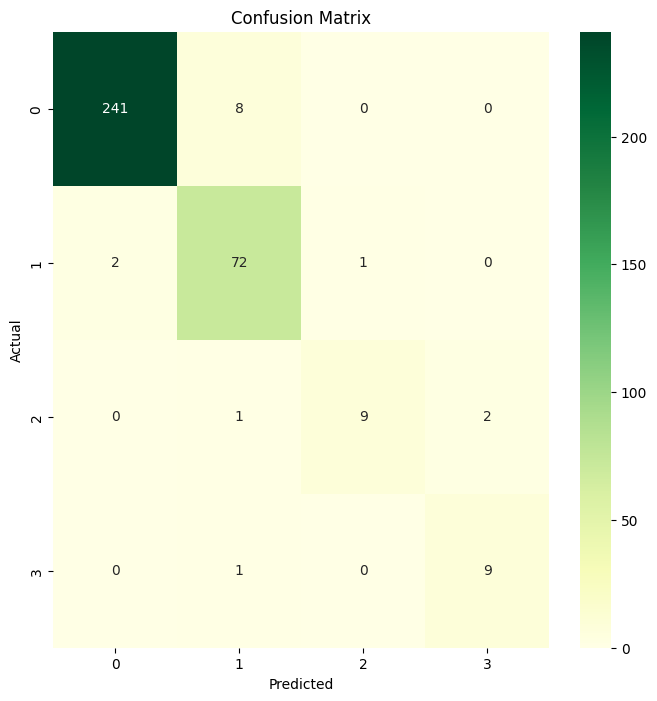

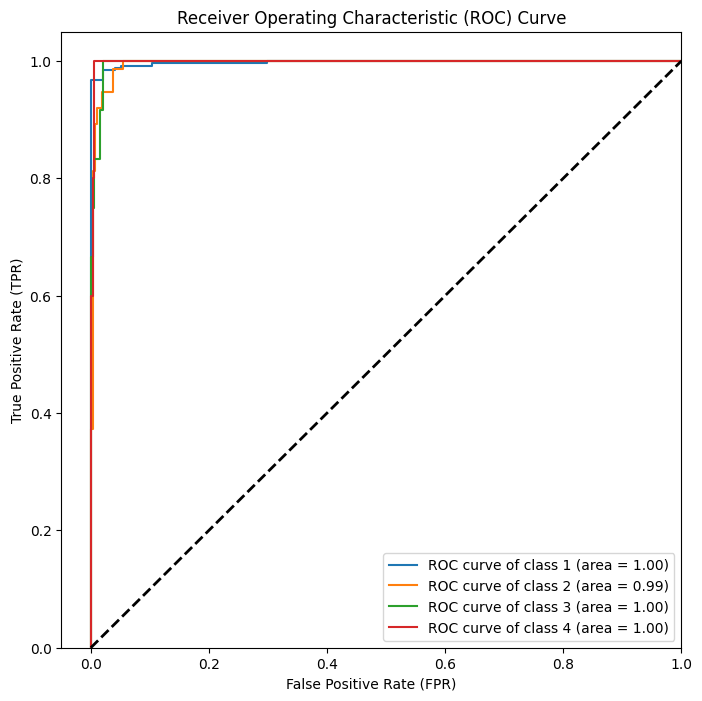

ROC AUC Score:  0.997
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       249
           1       0.88      0.96      0.92        75
           2       0.90      0.75      0.82        12
           3       0.82      0.90      0.86        10

    accuracy                           0.96       346
   macro avg       0.90      0.89      0.89       346
weighted avg       0.96      0.96      0.96       346



In [39]:
display_conf_matrix(confusion_matrix(y_test, y_pred))
display_roc_curve(y_test, y_score)
display_classification_report(y_test, y_pred)

## XGboost

In [40]:
xgb = XGBRFClassifier(random_state=75)
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc_ovr')
grid_search_xgb.fit(x_train, y_train)
print('Best Parameters: ', grid_search_xgb.best_params_)
print('Best Score: ', grid_search_xgb.best_score_)

Best Parameters:  {'max_depth': 10, 'n_estimators': 100}
Best Score:  0.9969386539477879


In [41]:
xgb_best = grid_search_xgb.best_estimator_
y_pred, y_score = xgb_best.predict(x_test), xgb_best.predict_proba(x_test)

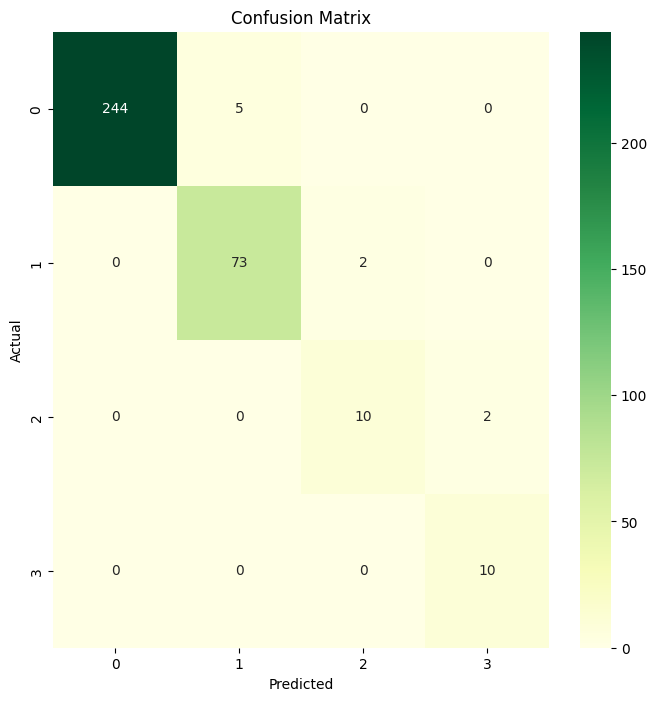

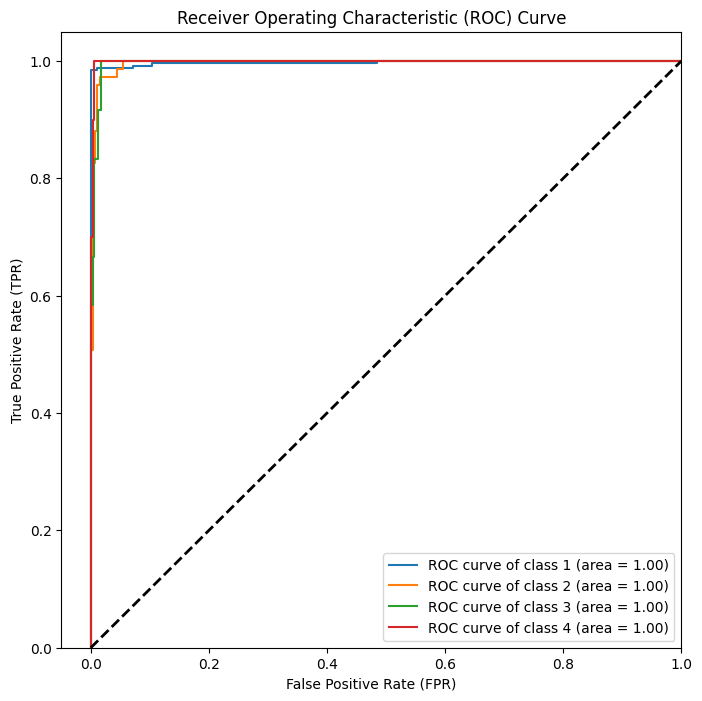

ROC AUC Score:  0.997
Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       249
           1       0.94      0.97      0.95        75
           2       0.83      0.83      0.83        12
           3       0.83      1.00      0.91        10

    accuracy                           0.97       346
   macro avg       0.90      0.95      0.92       346
weighted avg       0.98      0.97      0.97       346



In [42]:
display_conf_matrix(confusion_matrix(y_test, y_pred))
display_roc_curve(y_test, y_score)
display_classification_report(y_test, y_pred)